In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

from os import path
import sys
sys.path.append(path.abspath('..'))

In [30]:
import numpy as np
import torch
from tqdm.notebook import tqdm

from PIL import Image
import jpeg4py as jpeg

from src.dataset import PlatesCodeDataset
from src.lightning_module import OCRModule
from src.transforms import get_transforms
from src.predict_utils import matrix_to_string

In [4]:
DEVICE = 'cuda:0'
VOCAB = '#&0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÄÅÖÜĆČĐŠŽАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯ'

In [5]:
transforms = get_transforms(width=416, height=64, text_size=10, vocab=VOCAB, postprocessing=True, augmentations=False)

In [10]:
dataset=PlatesCodeDataset(
    phase='test',
    data_folder='../data/',
    reset_flag=False,
    # transforms=transforms,
)

In [8]:
module = OCRModule.load_from_checkpoint('../experiments/exp1/epoch_epoch=20-valid_string_match=0.965.ckpt')
_ = module.to(DEVICE)
_ = module.eval()

In [12]:
gt_texts = []
pr_texts = []

for i in tqdm(range(len(dataset))):
    image, text, _, _ = dataset[i]

    transformed_image = transforms(image=image, text='')['image']
    predict = module(transformed_image[None].to(DEVICE)).cpu().detach()
    string_pred, _ = matrix_to_string(predict, VOCAB)

    gt_texts.append(text)
    pr_texts.append(string_pred[0])

gt_texts = np.array(gt_texts)
pr_texts = np.array(pr_texts)

  0%|          | 0/175879 [00:00<?, ?it/s]

In [13]:
print(f'accuracy = {np.mean(gt_texts == pr_texts)}')

accuracy = 0.9496585720864913


In [14]:
# ошибочные индексы
np.where(gt_texts != pr_texts)[0]

array([     0,      1,      2, ..., 175871, 175874, 175878])

torch.Size([1, 3, 64, 416]) torch.Size([1, 3, 64, 416])
pred = KL805DM
true = KL805DM


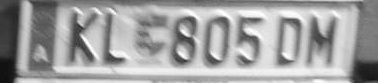

In [25]:
import random
random_idx = random.randint(0, len(dataset) - 1)
idx = random_idx
image, text, _, _ = dataset[idx]
transformed_image = transforms(image=image, text='')['image']
dummy_input = torch.rand(1, 3, 64, 416, device=DEVICE)
print(transformed_image[None].shape, dummy_input.shape)
print(f'pred = {pr_texts[idx]}')
print(f'true = {gt_texts[idx]}')
Image.fromarray(image)

In [20]:
import onnxruntime as ort
import onnx

In [27]:
# Convert to onnx
ONNX_MODEL_NAME = '../experiments/exp1/exp-1_plate-ocr-model.onnx'
DEVICE = 'cuda'
BATCH_SIZE = 1

dummy_input = torch.rand(1, 3, 64, 416, device=DEVICE)
torch.onnx.export(
    module,
    dummy_input,
    ONNX_MODEL_NAME,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes = {'input': [0], 'output': [0]}, # динамический батч, но можно и статический
)

In [28]:
# проверяем, что модель конвертнулась успешно
onnx_model = onnx.load(ONNX_MODEL_NAME)
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph main_graph (
  %input[FLOAT, input_dynamic_axes_1x3x64x416]
) initializers (
  %_model.gate.weight[FLOAT, 48x128x1x1]
  %_model.fc.bias[FLOAT, 60]
  %onnx::Conv_416[FLOAT, 64x3x7x7]
  %onnx::Conv_417[FLOAT, 64]
  %onnx::Conv_419[FLOAT, 64x64x3x3]
  %onnx::Conv_420[FLOAT, 64]
  %onnx::Conv_422[FLOAT, 64x64x3x3]
  %onnx::Conv_423[FLOAT, 64]
  %onnx::Conv_425[FLOAT, 64x64x3x3]
  %onnx::Conv_426[FLOAT, 64]
  %onnx::Conv_428[FLOAT, 64x64x3x3]
  %onnx::Conv_429[FLOAT, 64]
  %onnx::Conv_431[FLOAT, 128x64x3x3]
  %onnx::Conv_432[FLOAT, 128]
  %onnx::Conv_434[FLOAT, 128x128x3x3]
  %onnx::Conv_435[FLOAT, 128]
  %onnx::Conv_437[FLOAT, 128x64x1x1]
  %onnx::Conv_438[FLOAT, 128]
  %onnx::Conv_440[FLOAT, 128x128x3x3]
  %onnx::Conv_441[FLOAT, 128]
  %onnx::Conv_443[FLOAT, 128x128x3x3]
  %onnx::Conv_444[FLOAT, 128]
  %onnx::GRU_487[FLOAT, 2x384]
  %onnx::GRU_488[FLOAT, 2x192x384]
  %onnx::GRU_489[FLOAT, 2x192x64]
  %onnx::GRU_530[FLOAT, 2x384]
  %onnx::GRU_531[FLOAT, 2x192x128]
  %onnx::GRU_532[FL

In [29]:
# Инициализируем сессию

# При инициализации сессии можно указать несколько провайдеров. Это может быть полезно, если хотим запускать код
# на разных машинах. Например на машине с GPU у нас сработает CUDAExecutionProvider,
# а на машине без GPU CPUExecutionProvider
providers = [
    # 'CUDAExecutionProvider',
    'CPUExecutionProvider',
]

ort_session = ort.InferenceSession(
    ONNX_MODEL_NAME,
    providers=providers
)

print(f'{[input_.name for input_ in ort_session.get_inputs()]}')
print(f'{[output_.name for output_ in ort_session.get_outputs()]}')

['input']
['output']


In [40]:
# готовим входной тензор

BATCH_SIZE = 1
test_1 = '../data/dataset-plates/rus/test/img_140_20170102_080138_277_2215533.jpg'
test_2 = '../data/dataset-plates/rus_tl/test/6033578.jpg'
image = jpeg.JPEG(test_2).decode()
onnx_input = transforms(image=image, text='')['image'][None]
onnx_input = np.concatenate([onnx_input] * BATCH_SIZE)
print(onnx_input.shape)

ort_inputs = {ort_session.get_inputs()[0].name: onnx_input}
print(list(ort_inputs.keys()))

(1, 3, 64, 416)
['input']


In [41]:
# выполняем инференс ONNX Runtime
ort_outputs = ort_session.run(None, ort_inputs)[0]
print(ort_outputs.shape)

string_pred, _ = matrix_to_string(torch.from_numpy(ort_outputs), VOCAB)

(52, 1, 60)


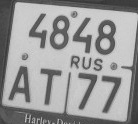

['4848AT77']

In [42]:
Image.fromarray(image)
string_pred